In [119]:
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

from model.utils.transfroms import get_train_transform, get_valid_transform, get_test_transform
from model.dataset import CustomDataset

HOME = ''
HOME_DIR = f'../Data/ChEMBL/OCR_RGB_0'
DATAFRAME_LIST = dict(train=f'data/chembl_31_smiles_train.csv',
                        val=f'data/chembl_31_smiles_val.csv',
                        test=f'data/chembl_31_smiles_test.csv')

def collate_fn(batch):
    return tuple(zip(*batch))

ocr_dataset = CustomDataset(
        data_df=DATAFRAME_LIST['val'],
        # mode='val',
        mode='test',
        # transforms=get_valid_transform(),
        # transforms=get_train_transform(),
        transforms=get_test_transform(),
        dir_path=HOME_DIR,
    )


Finished 'CustomDataset' in 0.0045 secs


In [ ]:
image, gt_shr, gt_shr_mask, gt_thr, gt_thr_mask = ocr_dataset[14]

fig, ax = plt.subplots(1, 5, figsize=(24, 6))
ax[0].imshow(image[0])
ax[1].imshow(gt_shr)
ax[2].imshow(gt_shr_mask)
ax[3].imshow(gt_thr)
ax[4].imshow(gt_thr_mask)

In [2]:
import torch
from torch import Tensor

from model.dbnet import DBNet
from model.loss import DBLoss

model = DBNet(
        inner_channels=192,
        out_channels=96,
        head_in_channels=480,
        # inner_channels=128,
        # out_channels=64,
        # head_in_channels=320,
        test=True,
    )

# model.load_state_dict(torch.load('model_weights.v9.mbv3s.final.pth'), strict=False)
model.load_state_dict(torch.load('model_weights.v9_rgb.mbv3s.5n192h480.final.pth'))
# model.load_state_dict(torch.load('model_weights.v9_rgb.mbv3s.5n192h480.50.pth'))
model.cpu()
model.eval()

idx = 0

In [ ]:
# image, gt_shr, gt_shr_mask, gt_thr, gt_thr_mask = ocr_dataset[idx]
image = ocr_dataset[idx]
# image = ocr_dataset[54]
image = image[None,]

x = model(image)
print(idx)

fig, ax = plt.subplots(2, 4, figsize=(24, 10))
ax[0, 0].imshow(image[0].permute([1, 2, 0]).detach().numpy())
# ax[0, 1].imshow(x[0, 0].detach().numpy())
# ax[0, 2].imshow(x[0, 1].detach().numpy())
# ax[0, 3].imshow(x[0, 2].detach().numpy())
ax[0, 1].imshow(x[0, 1].detach().numpy())
ax[0, 2].imshow(x[0, 2].detach().numpy())
ax[0, 3].imshow(x[0, 3].detach().numpy())
ax[1, 0].imshow(x[0, 4].detach().numpy())
ax[1, 1].imshow(x[0, 5].detach().numpy())
ax[1, 2].imshow(x[0, 6].detach().numpy())
ax[1, 3].imshow(x[0, 7].detach().numpy())
# ax[1, 0].imshow(gt_shr.detach().numpy())
# ax[1, 1].imshow(gt_shr.detach().numpy() == 5)
# ax[1, 2].imshow(gt_shr.detach().numpy() == 6)
# ax[1, 3].imshow(gt_shr.detach().numpy() == 7)

idx += 1

In [15]:
import cv2

from PIL import Image
from datetime import datetime

def save_image(img, pred, idx):
    now = datetime.now()
    cur_time_str = now.strftime("%d%m%Y_%H%M%S")

    img = np.array(img*255, dtype=np.uint8)
    pil_image = Image.fromarray(img, mode="L")
    pil_image.save(f"tmp_img/{cur_time_str}_{idx}_{pred}.png")


In [97]:
from utils.parser import get_mol_conn_info, get_mol
from utils.emnist import PredictAtomChar

def rule_func(pred):
    if pred in ["0", "D", "Q"]:
        pred = "O"
    elif pred in ["n"]:
        pred = "N"
    elif pred in ["z", "Z"]:
        pred = "2"
    elif pred in ["a"]:
        pred = "Cl"
    # elif pred in ["E", "t"]:
    #     pred = "F"
    elif pred in ["5"]:
        pred = "S"
    return pred

char_model = PredictAtomChar(return_img=True, rule_func=rule_func)

In [96]:
del char_model

NameError: name 'char_model' is not defined

In [7]:
_idx = 500

In [5]:
import re

In [48]:
def _func(idx):
    result = re.findall('(?![cCnNoOhHF\(\/\)\=\[\]0-9)@#]).', ocr_dataset.df.canonical_smiles[_idx])
    print(result)
    return result

def denormalize(x, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    # 3, H, W, B
    ten = x.clone()
    for t, m, s in zip(ten, mean, std):
        t.mul_(s).add_(m)
    # B, 3, H, W
    ten = ten.permute(1, 2, 0)
    return torch.clamp(ten, 0, 1).detach().numpy()

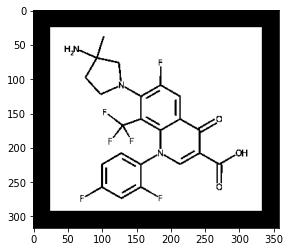

In [60]:
def pre_img(_img):
    # y = .2126 * _img[:, :, 2] + .7152 * _img[:, :, 1] + .0722 * _img[:, :, 0]
    y = .33 * _img[:, :, 2] + .33 * _img[:, :, 1] + .33 * _img[:, :, 0]
    # y = 0.33 * _img[:, 0, :, :] + 0.33 * _img[:, 1, :, :] + 0.33 * _img[:, 2, :, :]
    # y = ((y > 0.8).to(dtype=torch.float32) - 0.5) / 0.22
    y = y > 0.8
    return y[:, :, None]

plt.imshow(pre_img(denormalize(image[0])), cmap='gray')

In [120]:
print(f"----- {_idx} -----")
# while _func(_idx).__len__() == 0:
#     _idx += 1
# else:
image = ocr_dataset[_idx]
# image = ocr_dataset[253]
# image, gt_shr, gt_shr_mask, gt_thr, gt_thr_mask = ocr_dataset[2]
image = image[None,]

neck_out = model.neck(image)
out = model.head(neck_out)
out = out.detach().cpu().numpy()

contours, b_pair, pred_heavy_char_list, pred_char_list, pred_img_char_list = get_mol_conn_info(out, image, char_model=char_model)

_idx += 1

try:
    mol, smi = get_mol(contours, pred_heavy_char_list, b_pair)
    print(smi)
except:
    for idx, img in enumerate(pred_img_char_list):
        save_image(img[:, :, 0], pred_char_list[idx], idx)
    print('ERROR')

----- 532 -----
ERROR


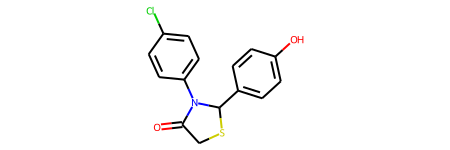

In [121]:
mol

In [27]:
for idx, img in enumerate(pred_img_char_list):
    save_image(img[:, :, 0], pred_char_list[idx], idx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


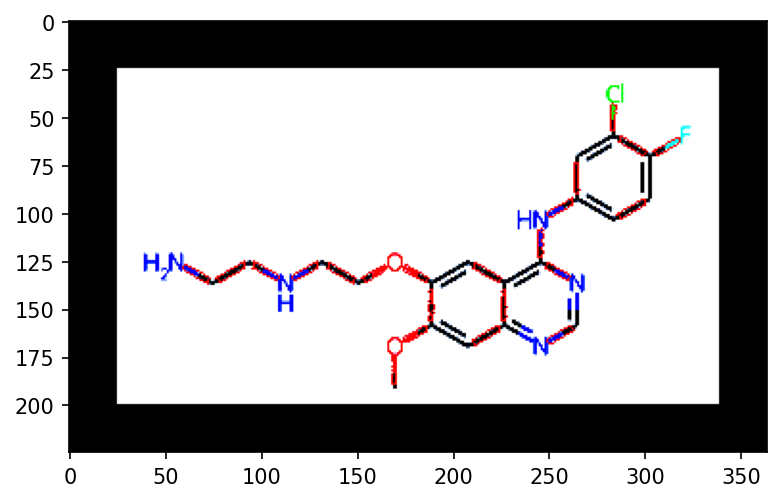

In [122]:
fig, ax = plt.subplots(1, 1, dpi=150)
img = image[0].permute(1, 2, 0).detach().numpy().copy()
_contours, _ = cv2.findContours(255*np.array(out[0][3] > 0.1, dtype=np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
tmp_contours = []
for _polygon in _contours:
    if _polygon.shape.__len__() > 1:
        rect = cv2.minAreaRect(_polygon)
        (x, y), (w, h), ang = rect
        # print(w*h)
        if w * h > 5:
            tmp_contours.append(_polygon)
ax.imshow(cv2.drawContours(img, tmp_contours, -1, (5), 1))

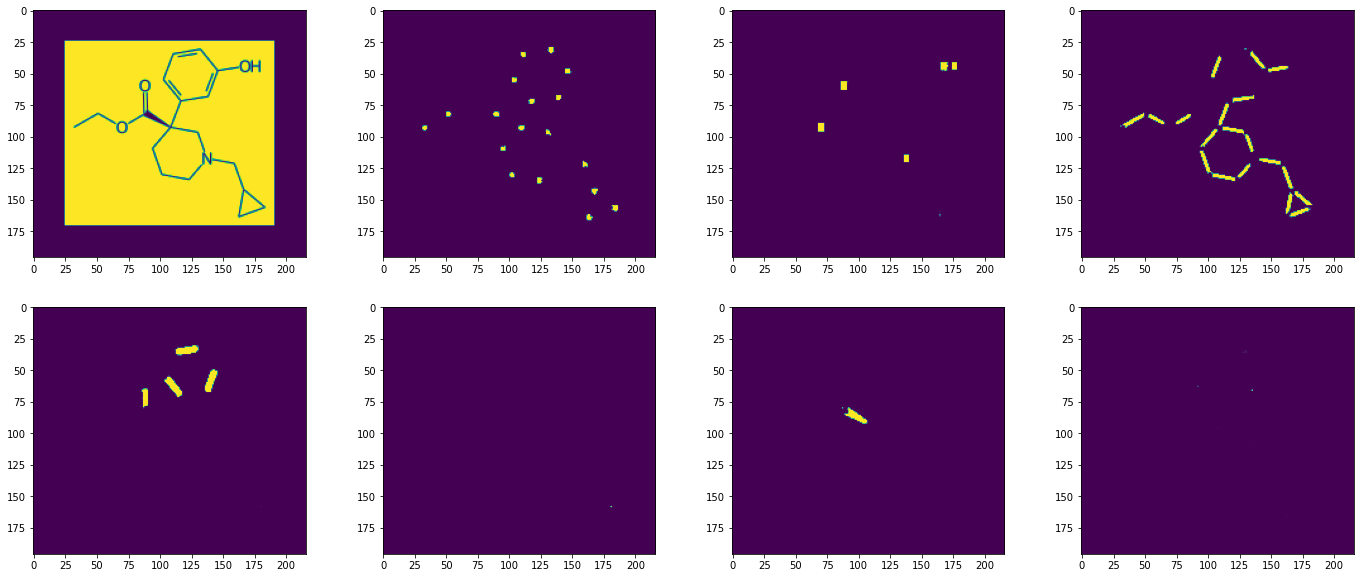

In [106]:
fig, ax = plt.subplots(2, 4, figsize=(24, 10))
ax[0, 0].imshow(image[0, 0].detach().numpy())
# ax[0, 1].imshow(x[0, 0].detach().numpy())
# ax[0, 2].imshow(x[0, 3].detach().numpy())
ax[0, 1].imshow(out[0, 1])
ax[0, 2].imshow(out[0, 2])
ax[0, 3].imshow(out[0, 3])
ax[1, 0].imshow(out[0, 4])
ax[1, 1].imshow(out[0, 5])
ax[1, 2].imshow(out[0, 6])
ax[1, 3].imshow(out[0, 7])

idx += 1

In [22]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = False

In [ ]:
b_pair[4]

In [ ]:
b_pair[3][19]

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=150)
# for i in contours[1]: plt.scatter(i[0], i[1], s=4200, c='none', edgecolors='k', alpha=0.2)
ax.imshow(image[0, 0].detach().numpy(), alpha=0.5, cmap='gray')

k = 0
for i in contours[1]: ax.scatter(i[0], i[1], s=10, c='k', alpha=0.5)
for i in contours[1]: ax.text(i[0], i[1]-1, k, fontsize=7); k += 1
# k = 0
# for i in contours[2]: ax.scatter(i[0], i[1], s=4200, c='none', edgecolors='b', alpha=0.2)
for i in contours[2]: ax.scatter(i[0], i[1], s=10, c='b', alpha=0.5)
for i in contours[2]: ax.text(i[0]+2, i[1]-2, k, fontsize=7); k += 1

if contours[3] is not None:
    k = 0
    for i in contours[3]: ax.scatter(i[0], i[1], c='gray', s=10, alpha=0.5)
    for i in contours[3]: ax.text(i[0]+2, i[1]+2, k, c='gray', fontsize=7); k += 1
if contours[4] is not None:
    k = 0
    for i in contours[4]: ax.scatter(i[0], i[1], c='r', s=10, alpha=0.5)
    for i in contours[4]: ax.text(i[0]+2, i[1]+2, k, c='r', fontsize=7); k += 1
if contours[5] is not None:
    k = 0
    for i in contours[5]: ax.scatter(i[0], i[1], c='g', s=10, alpha=0.5)
    for i in contours[5]: ax.text(i[0]+2, i[1]+2, k, c='g', fontsize=7); k += 1
if contours[6] is not None:
    k = 0
    for i in contours[6]: ax.scatter(i[0], i[1], c='b', s=10, alpha=0.5)
    for i in contours[6]: ax.text(i[0]+2, i[1]+2, k, c='b', fontsize=7); k += 1
if contours[7] is not None:
    k = 0
    for i in contours[7]: ax.scatter(i[0], i[1], c='navy', s=10, alpha=0.5)
    for i in contours[7]: ax.text(i[0]+2, i[1]+2, k, c='navy', fontsize=7); k += 1